In [ ]:
!pip install -q dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 58.4 MB/s eta 0:00:00


In [ ]:
import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from time import time

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
device1 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

### Helper functions

In [ ]:
# The MODEL
# Number of layers can be changed
class Graph_conv_net(nn.Module):
    def __init__(self, input_features, hidden_size, number_classes, dropout, device1):
        super(Graph_conv_net, self).__init__()
        self.conv1 = GraphConv(input_features, hidden_size).to(device1)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device1)
        # self.conv3 = GraphConv(hidden_size//2, number_classes).to(device1)
        self.dropout_frac = dropout

    def forward(self, g, inputs):

        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout_frac)
        h = self.conv2(g, h)
        # h = torch.relu(h)
        # h = F.dropout(h, p=self.dropout_frac)
        # h = self.conv3(g, h)
        h = torch.tanh(h)

        return h

In [ ]:
def generate_graph(n, d=None, p=None, graph_type='reg', random_seed=0):
    """
    Helper function to generate a NetworkX random graph of specified type,
    given specified parameters (e.g. d-regular, d=3). Must provide one of
    d or p, d with graph_type='reg', and p with graph_type in ['prob', 'erdos'].

    Input:
        n: Problem size
        d: [Optional] Degree of each node in graph
        p: [Optional] Probability of edge between two nodes
        graph_type: Specifies graph type to generate
        random_seed: Seed value for random generator
    Output:
        nx_graph: NetworkX OrderedGraph of specified type and parameters
    """
    if graph_type == 'reg':
        print(f'Generating d-regular graph with n={n}, d={d}, seed={random_seed}')
        nx_temp = nx.random_regular_graph(d=d, n=n, seed=random_seed)
    elif graph_type == 'prob':
        print(f'Generating p-probabilistic graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = gnp_random_connected_graph(n, p)
    elif graph_type == 'erdos':
        print(f'Generating erdos-renyi graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.erdos_renyi_graph(n, p, seed=random_seed)
    else:
        raise NotImplementedError(f'!! Graph type {graph_type} not handled !!')

    # Networkx does not enforce node order by default
    nx_temp = nx.relabel.convert_node_labels_to_integers(nx_temp)
    # Need to pull nx graph into OrderedGraph so training will work properly
    nx_graph = nx.OrderedGraph()
    nx_graph.add_nodes_from(sorted(nx_temp.nodes()))
    nx_graph.add_edges_from(nx_temp.edges)
    return nx_graph

In [ ]:
# Converting QUBO matrix dictionary to torch tensor
def qubo_dict_to_torch(nx_G, Q, torch_dtype=None, torch_device=None):
    n_nodes = len(nx_G.nodes)
    Q_mat = torch.zeros(n_nodes, n_nodes)
    for (x_coord, y_coord), val in Q.items():
        # if (x_coord<800):
        # print(x_coord, y_coord)
        Q_mat[x_coord][y_coord] = int(val)
    if torch_dtype is not None:
        Q_mat = Q_mat.type(torch_dtype)
    if torch_device is not None:
        Q_mat = Q_mat.to(torch_device)
    return Q_mat

In [ ]:
# LOSS function
def loss_func(probs, Q_matrix):
    # probs = 2*probs - 1
    probs_ = torch.unsqueeze(probs, 1)
    # probs_ = 2*probs_ - 1
    # print(probs_)
    cost = (probs_.T @ Q_matrix @ probs_).squeeze()
    # print()
    return cost

In [ ]:
# Creating an instance of model, embedding and optimizer
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):

    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    net = Graph_conv_net(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

In [ ]:
# Training Loop
def run_gnn_training(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold):
  
    inputs = embed.weight
    prev_loss = 1.
    count = 0
    # print(q_torch)

    best_bitstring = ((2*torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype))-1).to(q_torch.device)
    best_loss = loss_func(best_bitstring.float(), q_torch)

    # print("best_bitstring_shape", best_bitstring)
    # print("best_loss_shape", best_loss)

    t_gnn_start = time()

    for epoch in range(number_epochs):
        probs = net(dgl_graph, inputs)[:, 0]
        probs = 2*probs-1
        loss = loss_func(probs, q_torch)
        loss_ = loss.detach().item()
        # print(loss_)
        # print(probs.detach())
        bitstring = (probs.detach() >= prob_threshold) * 2 - 1
        # print("Epoch ones", bitstring)
        if loss < best_loss:
            best_loss = loss
            best_bitstring = bitstring

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss_}')
            

        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            break

        prev_loss = loss_
        # print(best_bitstring)
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()      

    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')
    prob_final = probs.detach()
    final_bitstring = (probs.detach() >= prob_threshold) * 2 - 1

    return net, epoch, final_bitstring, best_bitstring, prob_final

In [ ]:
# for GP problem
def gen_q_gp(nx_G):
    Q_dic = defaultdict(int)
    
    for i, j, k in nx_G.edges:
        # Q_dic[(i,i)]+= -1
        # Q_dic[(j,j)]+= -1
        Q_dic[(i,j)] = -1 + 8
        Q_dic[(j,i)] = -1 + 8
    for i, j in nx_G.degree:
        Q_dic[(i,i)] = j + 8

    return Q_dic

In [ ]:
# Post Processing 
def postprocess_gnn_gp(best_bitstring, nx_graph):

    bitstring_list = list(best_bitstring)
    size_set_1 = bitstring_list.count(1)
    size_set_2 = len(bitstring_list) - size_set_1
    
    set_1 = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    set_2 = set([node for node, entry in enumerate(bitstring_list) if entry == -1])
    edge_set = set(list(nx_graph.edges))

    
    return size_set_1, size_set_2, set_1, set_2



### Parameter intialization

In [ ]:
# Graph hypers
n = 5
d = 2
p = 0.25
graph_type = 'prob'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0

# Early stopping to allow NN to train to near-completion
tol = 1e-4         # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 200

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

In [ ]:
print(hidden_dim)

7


In [ ]:
# fix seed to ensure consistent results
seed_value = 5
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


### Code for randomly generated random graphs

In [ ]:
# for MaxCut problem
def gen_q_dict_gp(nx_G):
    Q_dic = defaultdict(int)
    
    for i, j in nx_G.edges:
        # Q_dic[(i,i)]+= -1
        # Q_dic[(j,j)]+= -1
        Q_dic[(i,j)] = -1  
        Q_dic[(j,i)] = -1 
    for i, j in nx_G.degree:
        Q_dic[(i,i)] = j 

    return Q_dic

In [ ]:
from itertools import groupby

In [ ]:
# Constructs a random d-regular or p-probabilistic graph
nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
#mu = 500
# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_gp(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

In [ ]:
q_torch

In [ ]:
import matplotlib.pyplot as plt
pos = nx.kamada_kawai_layout(nx_graph)
plt.figure(figsize=(12, 12))
nx.draw(nx_graph, pos = pos, node_size = 10, with_labels=False, node_color=[[.7, .7, .7]])

In [ ]:
pos = nx.kamada_kawai_layout(nx_graph)
# color_map = ['orange' if (best_bitstring[node]==-1) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=False, node_color=[[.7, .7, .7]], node_size = 10)

In [ ]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': 0,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}


net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [ ]:
q_torch = q_torch + 0.08

In [ ]:
print('Running GNN...')
gnn_start = time()

net, epoch, final_bitstring, best_bitstring, prob_final = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

In [ ]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_set_1, size_set_2, set_1, set_2 = postprocess_gnn_leak_detection(best_bitstring, nx_graph)

In [ ]:
size_set_1/size_set_2

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
# pos = nx.bipartite_layout(nx_graph, nodes = set_1, align='vertical')
color_map = ['orange' if (best_bitstring[node]==-1) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=False, node_color=color_map, node_size = 10)
# plt.savefig("/content//graph_ex_2.png", format="PNG", dpi = 300)
# plt.clf()

### For EPANET files

In [ ]:
!pip install -q wntr==0.5

In [ ]:
import wntr

In [ ]:
wn = wntr.network.WaterNetworkModel('/content/wolf-initial-fig.inp')

In [ ]:
G = wn.get_graph()
uG = G.to_undirected()

In [ ]:
node_positions = {node[0]: (node[1]['pos'][0], node[1]['pos'][1]) for node in G.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
nx.draw(G, pos=node_positions, node_size=5, node_color='black')
plt.title('Graph Representation', size=15)
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
nx.draw(uG, pos=node_positions, node_size=5, node_color='black')
# plt.title('Graph Representation of Sleeping Giant Trail Map', size=15)
plt.show()

### GP using Laplacian 

In [ ]:
L = (nx.laplacian_matrix(uG).toarray())

In [ ]:
node_positions_2 = {node[0]: (node[1]['pos'][0], node[1]['pos'][1]) for node in H.nodes(data=True)}

In [ ]:
L_eig, L_eigv = np.linalg.eig(L)

In [ ]:
ft = {}
for i in range(len(L_eig)):
  ft[L_eig[i]] = L_eigv[i]

In [ ]:
myKeys = list(ft.keys())
myKeys.sort()
sorted_dict = {i: ft[i] for i in myKeys}



In [ ]:
j=0
for i in sorted_dict:
  if j == 1:
    print(i)
    f_v = (sorted_dict[i])
    break
  j+=1

0.0005252206954291709


In [ ]:
classf = []
for i in f_v:
  if i>0:
    classf.append(1)
  else:
    classf.append(0)

In [ ]:
import matplotlib.pyplot as plt
# plt.clf()
plt.figure(figsize=(8, 6))
color_map = ["red" if c else "green" for c in classf]
nx.draw(uG, pos=node_positions, node_size=10,  node_color=color_map)
plt.title('GNN - Graph Partitioning : 407', size=10)
# plt.savefig('/content/GNN_GP_407.png', dpi=300)
plt.show()
# fig = plt.figure(

### GP using GNN

In [ ]:
# uG.edges
lab = {}
i = 0
for n in uG.nodes:
  lab[n] = i 
  i+=1
n = i

In [ ]:
# H = nx.convert_node_labels_to_integers(G.to_undirected())
H = nx.relabel_nodes(uG, lab)

In [ ]:
# for MaxCut problem
def gen_q_dict_gp(nx_G):
    Q_dic = defaultdict(int)
    
    for i, j, k in nx_G.edges: 
        # Q_dic[(i,i)]+= -1
        # Q_dic[(j,j)]+= -1
        Q_dic[(i,j)] = -1
        Q_dic[(j,i)] = -1
    for i, j in nx_G.degree:
        Q_dic[(i,i)] = j

    return Q_dic

In [ ]:
# Constructs a random d-regular or p-probabilistic graph
# nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=H)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
# mu = i
# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(H, gen_q_dict_gp(H), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
# uG.edges

In [ ]:
q_torch = q_torch + 0.08 # 0.08 -- value may change depending upon the input graph

In [ ]:
q_torch

In [ ]:
n = H.number_of_nodes()
print(n)

In [ ]:
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)

In [ ]:
print(dim_embedding ,hidden_dim)

In [ ]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': 1e-4}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': 0.00,
    'number_epochs': number_epochs,
    'tolerance': 1e-4,
    'patience': patience
}


net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [ ]:
print('Running GNN...')
gnn_start = time()

net, epoch, final_bitstring, best_bitstring, prob_final = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

In [ ]:
torch.median(prob_final)

In [ ]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_set_1, size_set_2, set_1, set_2 = postprocess_gnn_leak_detection(best_bitstring, H)
# gnn_tot_time = time() - gnn_start

In [ ]:
size_set_1/size_set_2

In [ ]:
# fig
# import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(8, 6))
color_map = ['orange' if (best_bitstring[node]==-1) else 'blue' for node in H.nodes]
nx.draw(uG, pos=node_positions, node_size=10,  node_color=color_map)
plt.title('GNN - Graph Partitioning : 407', size=10)
# plt.savefig('/content/GNN_GP_407.png', dpi=300)
plt.show()
# fig = plt.figure(figsize=(12,12))
# pos = nx.kamada_kawai_layout(H)
# color_map = ['orange' if (best_bitstring[node]==-1) else 'blue' for node in H.nodes]
# nx.draw(H, pos, with_labels=False, node_color=color_map, node_size = 10)

### GP using spectral clustering

In [ ]:
!pip install -q scikit-network

In [ ]:
A = nx.to_numpy_array(G)

In [ ]:
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
import numpy as np
n_clusters = 2
spectral_clusters = SpectralClustering(n_clusters=n_clusters, assign_labels="discretize", affinity='precomputed').fit_predict(A)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [ ]:
# fig
plt.clf()
plt.figure(figsize=(8, 6))
color_map = ["red" if c else "green" for c in spectral_clusters]
nx.draw(uG, pos=node_positions, node_size=10,  node_color=color_map)
plt.title('Spectral Clustering : 407', size=10)
# plt.savefig('/content/SC_GP_407.png', dpi=300)
plt.show()

In [ ]:
(H.number_of_nodes()-sum(spectral_clusters))/sum(spectral_clusters)

## Partitioning on subgraph (MSC)

In [ ]:
H_5_i = H.subgraph(set_2)

In [ ]:
new_s = []
for i,j in H_5_i.degree:
  if j != 0:
    new_s.append(i)

In [ ]:
H_5_i = H_5_i.subgraph(new_s)

In [ ]:
node_positions_5 = {node[0]: (node[1]['pos'][0], node[1]['pos'][1]) for node in H_5_i.nodes(data=True)}

In [ ]:
plt.clf()
plt.figure(figsize=(12, 12))
# color_map = ['orange' if (best_bitstring[node]==-1) else 'blue' for node in H.nodes]
nx.draw(H_5_i, pos=node_positions_5, node_size=20)
plt.title('Graph Representation', size=15)
plt.show()

In [ ]:
set_f = []
for i in node_positions_5:
  for j in node_positions:
    if (node_positions_5[i]==node_positions[j]):
      set_f.append(j)


In [ ]:
f_string = {}
for i in uG.nodes:
  if i in set_f:
    f_string[i] = -1
  else:
    f_string[i] = 1

<Figure size 432x288 with 0 Axes>

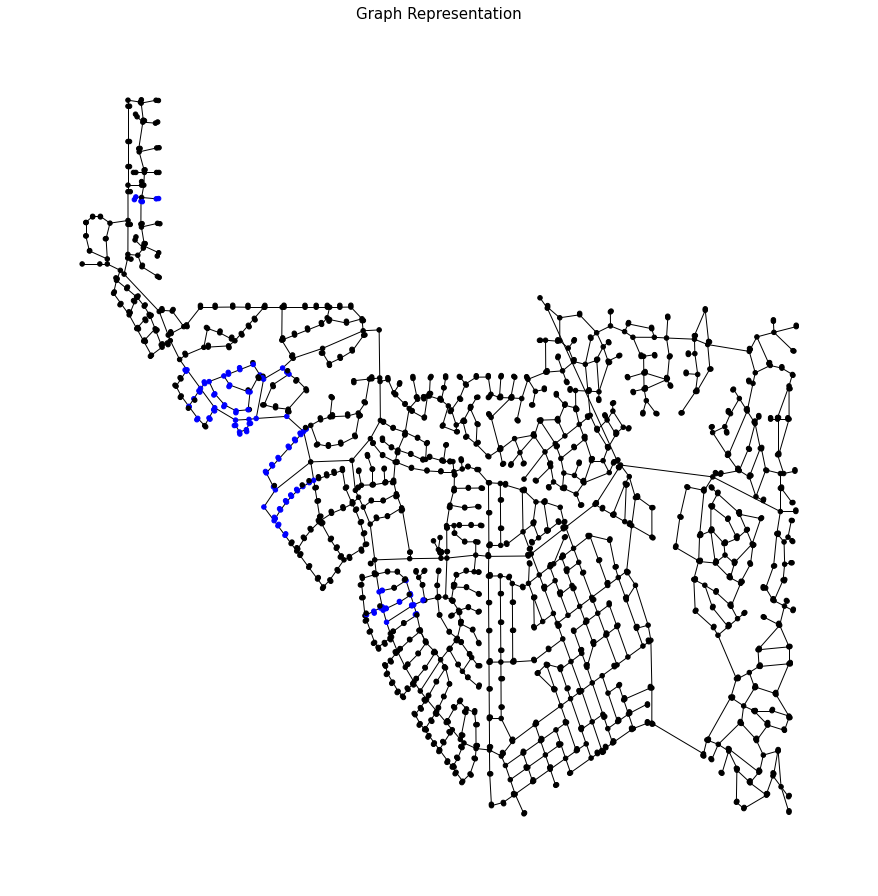

In [ ]:
plt.clf()
plt.figure(figsize=(12, 12))
color_map = ['blue' if (f_string[node]==-1) else 'black' for node in uG.nodes]
nx.draw(uG, pos=node_positions, node_size=20, node_color = color_map)
plt.title('Graph Representation', size=15)
plt.show()

In [ ]:
set_f_2 = []
for i in node_positions_4:
  for j in node_positions:
    if (node_positions_4[i]==node_positions[j]):
      set_f_2.append(j)

In [ ]:
f_string_2 = {}
for i in uG.nodes:
  if i in set_f_2:
    f_string_2[i] = -1
  else:
    f_string_2[i] = 1

<Figure size 432x288 with 0 Axes>

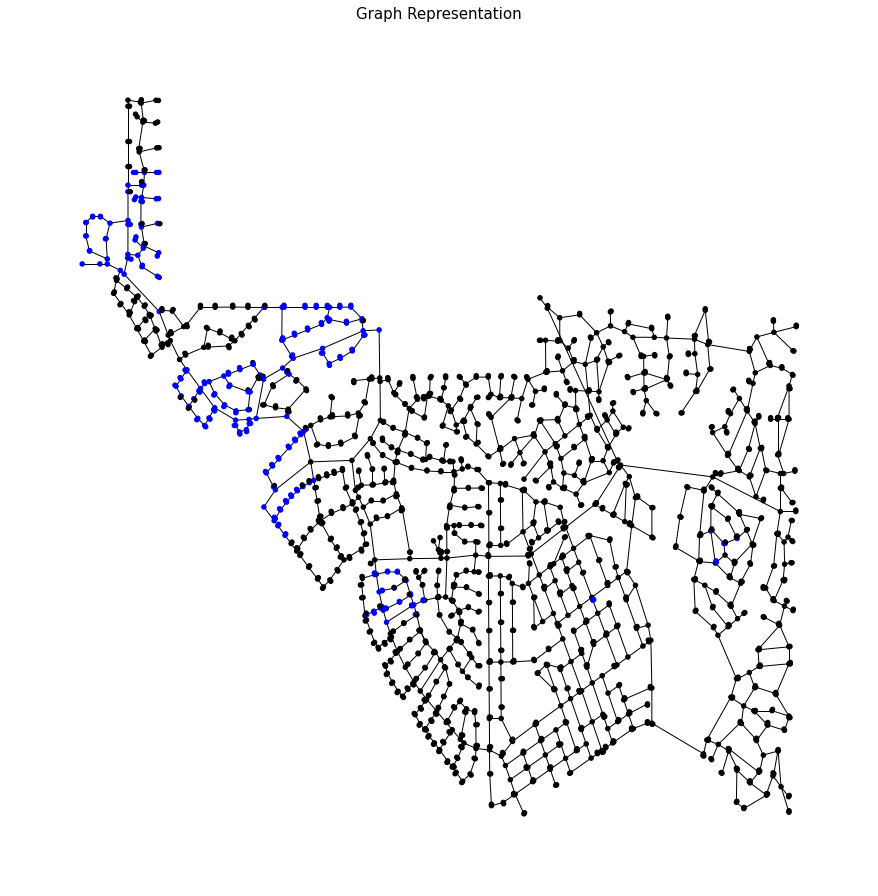

In [ ]:
plt.clf()
plt.figure(figsize=(12, 12))
color_map = ['blue' if (f_string_2[node]==-1) else 'black' for node in uG.nodes]
nx.draw(uG, pos=node_positions, node_size=20, node_color = color_map)
plt.title('Graph Representation', size=15)
plt.show()

In [ ]:
# plt.clf()
# plt.figure(figsize=(12, 12))
# color_map = ['blue' if node else 'black' for node in H_4.nodes]
# nx.draw(H, pos=node_positions, node_size=20)
# plt.title('Graph Representation', size=15)
# plt.show()
set_f_3 = []
for i in node_positions_3:
  for j in node_positions:
    if (node_positions_3[i]==node_positions[j]):
      set_f_3.append(j)
# node_positions

In [ ]:
f_string_3 = {}
for i in uG.nodes:
  if i in set_f_3:
    f_string_3[i] = -1
  else:
    f_string_3[i] = 1

<Figure size 432x288 with 0 Axes>

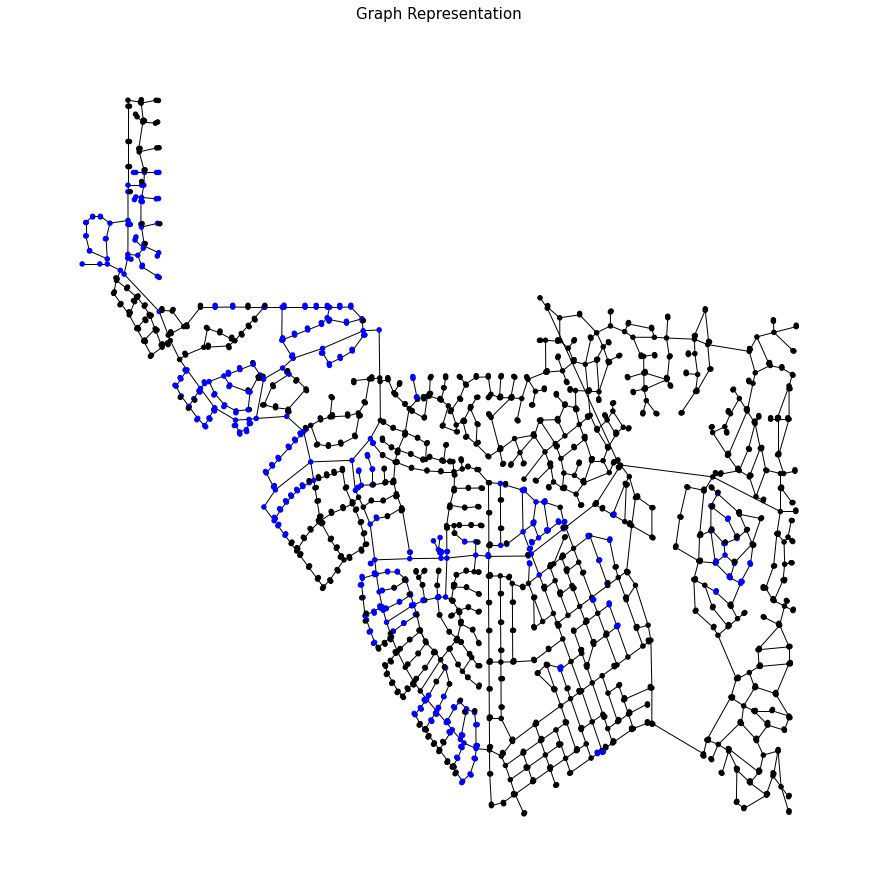

In [ ]:
plt.clf()
plt.figure(figsize=(12, 12))
color_map = ['blue' if (f_string_3[node]==-1) else 'black' for node in uG.nodes]
nx.draw(uG, pos=node_positions, node_size=20, node_color = color_map)
plt.title('Graph Representation', size=15)
plt.show()

In [ ]:
# plt.clf()
# plt.figure(figsize=(12, 12))
# color_map = ['blue' if node else 'black' for node in H_4.nodes]
# nx.draw(H, pos=node_positions, node_size=20)
# plt.title('Graph Representation', size=15)
# plt.show()
set_f_4 = []
for i in node_positions_2:
  for j in node_positions:
    if (node_positions_2[i]==node_positions[j]):
      set_f_4.append(j)
# node_positions

In [ ]:
f_string_4 = {}
for i in uG.nodes:
  if i in set_f_4:
    f_string_4[i] = -1
  else:
    f_string_4[i] = 1

<Figure size 432x288 with 0 Axes>

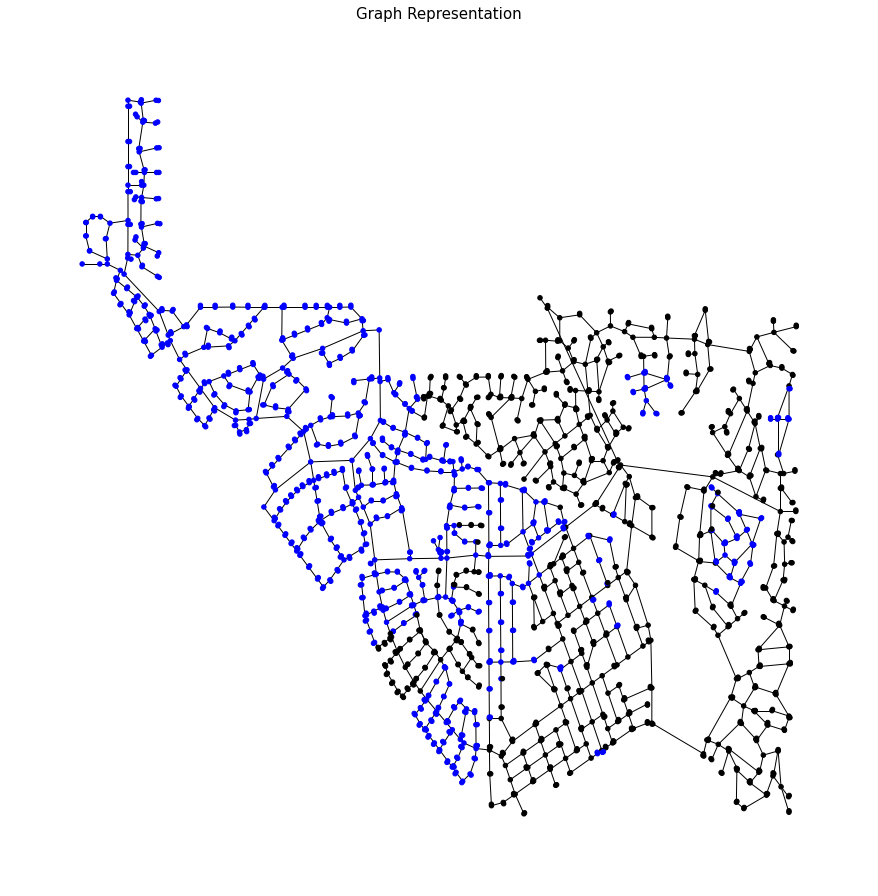

In [ ]:
plt.clf()
plt.figure(figsize=(12, 12))
color_map = ['blue' if (f_string_4[node]==-1) else 'black' for node in uG.nodes]
nx.draw(uG, pos=node_positions, node_size=20, node_color = color_map)
plt.title('Graph Representation', size=15)
plt.show()

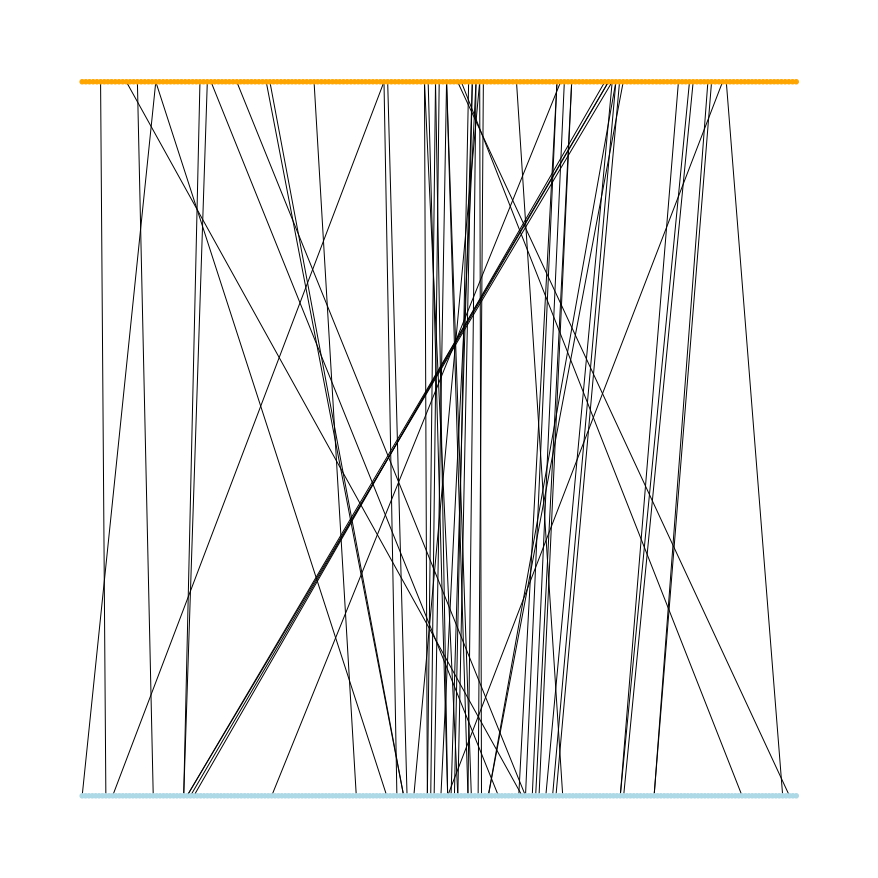

In [ ]:
fig = plt.figure(figsize=(12,12))
pos = nx.bipartite_layout(H, nodes = set_1, align='horizontal')
color_map = ['orange' if (best_bitstring[node]==-1) else 'lightblue' for node in H.nodes]
nx.draw(H, pos, with_labels=False, node_color=color_map, node_size = 20, font_size = 5)

In [ ]:
print(size_set_1/size_set_2)

1.0452261306532664


## Extra